# Classification using BFGS -- Pytorch version

This notebook details the implementation of a generic ridge-regularized classification solved by direct gradient-based optimization (here quasi-newton). 
It is implemented in the kernel space, i.e. representing the weights over the space of points.

In [9]:
%load_ext autoreload
%autoreload 2
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device_cpu = torch.device("cpu")
device_cpu = device
print( device )

mytype = torch.float16 # to save memory (only on GPU)
mytype = torch.float32

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'torch'

# Data

In [43]:
%load_ext autoreload
%autoreload 2

import utils
from utils import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### probleme dans la DB sur le cluster : un des smiles pose problème sur mon ordi avec Rdkit -> on l'enleve

In [44]:
df_DB = load_data()
print(df_DB.shape)
df_DB

(13717, 7)


,uniprot,DBid,smiles,ind2mol,fasta,ind2prot,inter
0,A0A024R8I1,DB00381,CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,213,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1
1,A0A024R8I1,DB00996,NCC1(CC(O)=O)CCCCC1,686,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1
2,A1L3X4,DB12965,[Ag],4672,MDLSCSCATGGSCTCASSCKCKEYKCTSCKKNCCSCCPMGCAKCAQGCT,1,1
3,A5X5Y0,DB00715,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...,462,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1
4,A5X5Y0,DB09304,CN1CCC2=C(C1)C1=CC=CC=C1CC1=CC=CC=C21,4467,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1
...,...,...,...,...,...,...,...
13712,Q9Y6R4,DB12010,COC1=CC(NC2=NC=C(F)C(NC3=NC4=C(OC(C)(C)C(=O)N4...,4597,MREAAAALVPPPAFAVTPAAAMEEPPPPPPPPPPPPEPETESEPEC...,2511,1
13713,Q9Y6Y9,DB00295,[H][C@@]12OC3=C(O)C=CC4=C3[C@@]11CCN(C)[C@]([H...,149,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,2512,1
13714,Q9Y6Y9,DB02767,[H][C@@](O)(CCCCCCCCCCC)CC(O)=O,1564,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,2512,1
13715,Q9Y6Y9,DB03017,CCCCCCCCCCCC(O)=O,1671,MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...,2512,1


In [45]:
print(df_DB[df_DB["smiles"] =="NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O"])
# drop the molecule with the error in rdkit
df_DB = df_DB.drop(12222)
df_DB[df_DB["smiles"] =="NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O"]


      uniprot     DBid                                  smiles  ind2mol  \
12222  Q86XF0  DB01929  NC1=C(C2=C(N)N=C(N)N=C2C=C1)[Cl](=O)=O     1169   

                                                   fasta  ind2prot  inter  
12222  MFLLLNCIVAVSQNMGIGKNGDLPRPPLRNEFRYFQRMTTTSSVEG...      1989      1  


,uniprot,DBid,smiles,ind2mol,fasta,ind2prot,inter


In [46]:
df_DB.shape

(13716, 7)

In [47]:
df_DB[["uniprot"]].drop_duplicates().shape

(2513, 1)

In [48]:
df_DB[["smiles"]].drop_duplicates().shape

(4813, 1)

In [49]:
df_DB[["ind2mol","smiles"]].drop_duplicates().shape

(4814, 2)

In [50]:
import numpy as np
# il faut renuméroter in2mol car il manque le numéro 1169
np.sort(df_DB["ind2mol"].unique()) == np.arange(0,df_DB["ind2mol"].unique().shape[0])

array([ True,  True,  True, ..., False, False, False])

In [51]:
# make dict smiles2ind and dict ind2smiles
df_sm = df_DB[["smiles"]].drop_duplicates().reset_index()
#df_sm = df_DB[["standardized smiles"]].drop_duplicates().reset_index()
df_sm.drop(columns=["index"],inplace=True)
dict_ind2smiles = df_sm.to_dict()["smiles"]
#dict_ind2smiles = df_sm.to_dict()["standardized smiles"]
print("nombre de smiles: ",len(dict_ind2smiles))
dict_smiles2ind = {v: k for k, v in dict_ind2smiles.items()}

nombre de smiles:  4813


In [52]:
# add this number to df_DB
df_DB["indsmiles"] = df_DB["smiles"].map(dict_smiles2ind)
# we drop when indsmiles is Nan
indsmiles_index_with_nan = df_DB.index[df_DB.loc[:,"indsmiles"].isnull()]
df_DB = df_DB.drop(indsmiles_index_with_nan,0)
df_DB["indsmiles"] = df_DB["indsmiles"].astype(int)
df_DB.head()

/var/folders/zg/y03kdtc553xg5q1ct59rj44c0000gn/T/ipykernel_95820/2334661099.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_DB = df_DB.drop(indsmiles_index_with_nan,0)


,uniprot,DBid,smiles,ind2mol,fasta,ind2prot,inter,indsmiles
0,A0A024R8I1,DB00381,CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,213,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1,0
1,A0A024R8I1,DB00996,NCC1(CC(O)=O)CCCCC1,686,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1,1
2,A1L3X4,DB12965,[Ag],4672,MDLSCSCATGGSCTCASSCKCKEYKCTSCKKNCCSCCPMGCAKCAQGCT,1,1,2
3,A5X5Y0,DB00715,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...,462,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1,3
4,A5X5Y0,DB09304,CN1CCC2=C(C1)C1=CC=CC=C1CC1=CC=CC=C21,4467,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1,4


In [53]:
# pas de pb pour les protéines
np.sort(df_DB["ind2prot"].unique()) == np.arange(0,df_DB["ind2prot"].unique().shape[0])

array([ True,  True,  True, ...,  True,  True,  True])

In [54]:
# on enleve la colonne ind2mol 
df_DB.drop(columns=["ind2mol"],inplace=True)
df_DB.head()

,uniprot,DBid,smiles,fasta,ind2prot,inter,indsmiles
0,A0A024R8I1,DB00381,CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1,0
1,A0A024R8I1,DB00996,NCC1(CC(O)=O)CCCCC1,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1,1
2,A1L3X4,DB12965,[Ag],MDLSCSCATGGSCTCASSCKCKEYKCTSCKKNCCSCCPMGCAKCAQGCT,1,1,2
3,A5X5Y0,DB00715,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1,3
4,A5X5Y0,DB09304,CN1CCC2=C(C1)C1=CC=CC=C1CC1=CC=CC=C21,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1,4


In [55]:
# on renomme ind2prot en indfasta
df_DB.rename(columns={"ind2prot":"indfasta",'inter': 'score'},inplace=True)
df_DB.head()


,uniprot,DBid,smiles,fasta,indfasta,score,indsmiles
0,A0A024R8I1,DB00381,CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1,0
1,A0A024R8I1,DB00996,NCC1(CC(O)=O)CCCCC1,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1,1
2,A1L3X4,DB12965,[Ag],MDLSCSCATGGSCTCASSCKCKEYKCTSCKKNCCSCCPMGCAKCAQGCT,1,1,2
3,A5X5Y0,DB00715,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1,3
4,A5X5Y0,DB09304,CN1CCC2=C(C1)C1=CC=CC=C1CC1=CC=CC=C21,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1,4


In [56]:
df_DB.to_csv('data/drugbank.csv', index=False)

## Kprot

In [365]:
import pickle
with open('data/Drugbank/K_prot.data', 'rb') as f:
        K_prot = pickle.load(f)

In [366]:
K_prot.shape

(2513, 2513)

## liste des 4814 smiles

In [352]:
# same in zip format
import pandas as pd
import zipfile
zf = zipfile.ZipFile('data/Drugbank/drugbank.csv.zip') 
df = pd.read_csv(zf.open('drugbank.csv'),low_memory=False)
df_p = df[df['inter'] == True]
#list of smiles strings
smiles = df_p['smiles'].drop_duplicates().values
len(smiles)

4813

In [353]:
from rdkit import Chem
from rdkit.Chem import AllChem

import numpy as np

nM =  len(smiles)
MorganFP = np.zeros((nM,1024))
for i in range(nM):
    # Convert SMILES to RDKit molecule object
    mol = Chem.MolFromSmiles(smiles[i])    
    # Generate Morgan fingerprint of the molecule
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    # Convert the fingerprint to a numpy array
    arr = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    MorganFP[i,:] = arr
MorganFP = MorganFP.astype(int)

[12:52:55] Unusual charge on atom 0 number of radical electrons set to zero


In [354]:
import Nystrom_method
from  Nystrom_method import nystroem,KronKernel
# random list of molecules 
kM = 4813 # number of molecule to compute nystrom
rM = 1000 # final dimension of features
I = np.random.permutation(nM)
I = I[:kM]

In [330]:
# compute Tanimoto kernel 
Km = ( MorganFP[I,:] @ MorganFP.T ) / ( 1024 - (1-MorganFP[I,:]) @ (1-MorganFP.T) )

In [331]:
Xm,Lambda,LambdaC = nystroem(np.concatenate((Km[:,I], Km), axis=1),rM)

## liste des indices protéines/molécules avec que des 1

## train/test avec indices protéines/molécules et interactions balanced

en premier l'indice de la protéine, puis l'indice du ligand puis l'interaction

In [372]:
# same in zip format
import pandas as pd
#import zipfile
#zf = zipfile.ZipFile('data/Drugbank/drugbank.csv.zip') 
#df = pd.read_csv(zf.open('drugbank.csv'),low_memory=False)
df = pd.read_csv('data/drugbank.csv',low_memory=False)
df_p = df[df['score'] == True]
#list of smiles strings
smiles = df_p['smiles'].drop_duplicates().values
len(smiles)

4813

In [373]:
# trouver les lignes identiques
intMat = df_p.pivot_table(index='indfasta', columns="indsmiles", values='score').to_numpy(dtype=np.float16)
intMat.shape
np.where(intMat == 0.5)

(2513, 4813)

In [374]:
np.where(intMat == 1)

(array([   0,    0,    1, ..., 2512, 2512, 2512]),
 array([   0,    1,    2, ...,   46,   48, 3681]))

In [376]:
from utils import make_train_test

all_train_interactions_arr, all_test_interactions_arr = make_train_test(df_p,5,1)

train (21944, 3)
test (5486, 3)
train (21944, 3)
test (5486, 3)
train (21944, 3)
test (5486, 3)
train (21944, 3)
test (5486, 3)
train (21944, 3)
test (5486, 3)
Train/test datasets prepared.


In [377]:
from utils import make_train_test_mol_orphan

all_train_interactions_arr, all_test_interactions_arr = make_train_test_mol_orphan(df,5)

train (21944, 3)
test (3299, 3)
train (21944, 3)
test (3320, 3)
train (21944, 3)
test (3300, 3)
train (21944, 3)
test (3300, 3)
train (21944, 3)
test (3304, 3)
Train/test datasets prepared.


In [381]:
train = all_train_interactions_arr[0]
test = all_test_interactions_arr[0]
S_train = set(map(tuple, train))
S_test = set(map(tuple, test))
S_train.intersection(S_test)

set()

In [382]:
for elt in test:
    for x in train:
        if elt[1]==x[1]:
            print(elt,x)

In [383]:
from utils import make_train_test_prot_orphan

all_train_interactions_arr, all_test_interactions_arr = make_train_test_prot_orphan(df,5)

train (21944, 3)
test (3295, 3)
train (21944, 3)
test (3288, 3)
train (21944, 3)
test (3261, 3)
train (21944, 3)
test (3331, 3)
train (21944, 3)
test (3259, 3)
Train/test datasets prepared.


In [384]:
train = all_train_interactions_arr[0]
test = all_test_interactions_arr[0]
S_train = set(map(tuple, train))
S_test = set(map(tuple, test))
S_train.intersection(S_test)

set()

In [385]:
for elt in test:
    for x in train:
        if elt[0]==x[0]:
            print(elt,x)

In [386]:
from utils import make_train_test_prot_mol_orphan

all_train_interactions_arr, all_test_interactions_arr = make_train_test_prot_mol_orphan(df,5)

train (11080, 3)
test (2229, 3)
train (11846, 3)
test (1975, 3)
train (10646, 3)
test (2437, 3)
train (11692, 3)
test (1926, 3)
train (11978, 3)
test (1763, 3)
Train/test datasets prepared.


In [387]:
train = all_train_interactions_arr[0]
test = all_test_interactions_arr[0]
S_train = set(map(tuple, train))
S_test = set(map(tuple, test))
S_train.intersection(S_test)

set()

In [388]:
for elt in test:
    for x in train:
        if elt[1]==x[1] or elt[0]==x[0]:
            print(elt,x)

## test de l'algo de train/test

In [31]:
# algo Matthieu corrected
import numpy as np
intMat = df.pivot(index='indfasta', columns="indsmiles", values='score').to_numpy(dtype=np.float16)
intMat

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float16)

In [10]:
n_p,n_m = intMat.shape
Ip, Jm = np.where(intMat==1)
print(Ip,Jm,intMat[0,213])
nb_positive_inter = int(len(Ip))
Inp, Jnm = np.where(intMat==0)
Inkp, Jnkm = np.where(np.isnan(intMat))
print(Inkp,Jnkm,intMat[0,0])


[   0    0    1 ... 2512 2512 2512] [ 213  686 4672 ... 1564 1671 3948] 1.0
[   0    0    0 ... 2512 2512 2512] [   0    1    2 ... 4812 4813 4814] nan


In [13]:
#from sklearn import model_selection
from sklearn.model_selection import GroupKFold
groups = np.array(Ip)
group_kfold = GroupKFold(n_splits=5)
#skf_positive = model_selection.KFold(shuffle=True, n_splits=5)
for train_index, test_index in group_kfold.split(range(nb_positive_inter), groups=groups):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [    0     1     2 ... 13709 13710 13712] TEST: [    3     4     5 ... 13714 13715 13716]
TRAIN: [    0     1     2 ... 13714 13715 13716] TEST: [    9    10    11 ... 13708 13709 13710]
TRAIN: [    0     1     2 ... 13714 13715 13716] TEST: [   31    32    33 ... 13699 13705 13712]
TRAIN: [    2     3     4 ... 13714 13715 13716] TEST: [    0     1    26 ... 13680 13682 13701]
TRAIN: [    0     1     3 ... 13714 13715 13716] TEST: [    2    24    25 ... 13702 13703 13704]


In [14]:
Ip[train_index],Jm[train_index],intMat[0,213]

(array([   0,    0,    2, ..., 2512, 2512, 2512]),
 array([ 213,  686,  462, ..., 1564, 1671, 3948]),
 1.0)

In [15]:
Ip[test_index],Jm[test_index],intMat[2,4675]

(array([   1,    4,    4, ..., 2506, 2506, 2506]),
 array([4672, 4369, 4740, ...,  863,  887, 2668]),
 nan)

In [16]:
Mm, bin_edges = np.histogram(Ip[train_index], bins = range(n_p+1)) 
Mp, bin_edges = np.histogram(Jm[train_index], bins = range(n_m+1))
train = np.zeros([1,3], dtype=int)
nb_prot = len(list(set(Ip[train_index])))
nb_prot

2010

In [17]:
for i in range(nb_prot):

        j = np.argmax(Mm) # choose protein with the maximum of interactions in the train

        indice_P = Jm[train_index][np.where(Ip[train_index]==j)[0]]  #np.array with index of interactions + in train
        indice_N = [k for k in Jm[train_index] if intMat[j][k]==0]
        indice_NK = [k for k in Jm[train_index] if np.isnan(intMat[j][k])] #np.array  with index of interactions not known

        indice_freq_mol = np.where(Mp>1)[0]  #drug's index with more than 2 interactions +
        indice_poss_mol = np.where(Mp == 1)[0]  #drug's index with 1 interaction +

        indice_freq_one_prot = np.intersect1d(indice_N, indice_freq_mol)
        indice_poss_one_prot = np.intersect1d(indice_N, indice_poss_mol)

        nb_positive_interactions = len(indice_P)
        nb_frequent_hitters_negative_interactions = len(indice_freq_one_prot)

        indice_freq_one_prot = np.intersect1d(indice_N, indice_freq_mol)
        indice_poss_one_prot = np.intersect1d(indice_N, indice_poss_mol)
        indice_freq_one_prot_NK = np.intersect1d(indice_NK, indice_freq_mol)
        indice_poss_one_prot_NK = np.intersect1d(indice_NK, indice_poss_mol)

        if len(indice_P) <= len(indice_freq_one_prot):
            # we shoot at random nb_positive_interactions in drugs with a lot of interactions
            indice_N_one_prot = np.random.choice(indice_freq_one_prot,
                                                len(indice_P), replace = False)
        elif len(indice_P) <= len(indice_freq_one_prot) + len(indice_poss_one_prot):
            # we shoot at random nb_positive_interactions in drugs with a lot of interactions
            nb_negative_interactions_remaining = len(indice_P) - len(indice_freq_one_prot)
            indice_N_one_prot_poss = np.random.choice(indice_poss_one_prot,
                                                    nb_negative_interactions_remaining, replace = False )
            indice_N_one_prot = np.concatenate((indice_freq_one_prot,
                                            indice_N_one_prot_poss))
        elif len(indice_P) <= len(indice_freq_one_prot) + len(indice_poss_one_prot) + len(indice_freq_one_prot_NK):
            # we shoot at random nb_positive_interactions in drugs with a lot of interactions
            nb_negative_interactions_remaining = len(indice_P) - len(indice_freq_one_prot) - len(indice_poss_one_prot)
            indice_N_one_prot_poss = np.random.choice(indice_freq_one_prot_NK,
                                                    nb_negative_interactions_remaining, replace = False )
            indice_N_one_prot = np.concatenate((indice_freq_one_prot,
                                            indice_poss_one_prot, indice_N_one_prot_poss))
        else:
            # we shoot at random nb_positive_interactions in drugs with a lot of interactions
            nb_negative_interactions_remaining = len(indice_P) - len(indice_freq_one_prot) - len(indice_poss_one_prot) - len(indice_freq_one_prot_NK)
            #print("nb_negative_interactions_remaining", nb_negative_interactions_remaining) # pas de solution...
            #print(indice_poss_one_prot_NK.shape)
            indice_N_one_prot_poss = np.random.choice(indice_poss_one_prot_NK,
                                                    nb_negative_interactions_remaining, replace = False )
            indice_N_one_prot = np.concatenate((indice_freq_one_prot,
                                            indice_poss_one_prot, indice_freq_one_prot_NK, indice_N_one_prot_poss))

        Mp[indice_N_one_prot.astype(int)]-=1

        # this protein has been processed
        Mm[j] = 0

        indice = np.r_[indice_P,indice_N_one_prot].astype(int)
        etiquette = [x if not np.isnan(x) else 0 for x in intMat[j][indice]]
        A = np.stack((indice, etiquette), axis=-1)
        B = np.c_[np.zeros(A.shape[0])+j,A].astype(int)
        train = np.concatenate((train,B))

        train = train[1:]

In [18]:
len(train)

19939

In [19]:
# test
#test_index =  np.random.choice(test_index, int(p*len(test_index)), replace=False)
# interactions + in test
indice_P_t = np.c_[Ip[test_index],Jm[test_index], np.ones(len(test_index))].astype(int)

# interactions - in test
a = np.r_[np.c_[Inp,Jnm]] # all the zeros in the matrix (and NK ?)
a1 = set(map(tuple, a))
b = train[:,:2]   # all the interactions in the train
b1 = set(map(tuple, b))
indice_N_t = np.array(list(a1 - b1))#[:indice_P_t.shape[0],:] # we keep the same number of interactions - than interactions + in test, choosing the 0 in the matrix
#print(len(indice_N_t))

# add interactions np.nan in test

if len(indice_N_t) == 0:
    # initialization
    indice_N_t = np.array([-1, -1]).reshape(1,2)

c = np.r_[np.c_[Inkp,Jnkm]] # all the np.nan in the matrix

if len(indice_N_t) < indice_P_t.shape[0]:
    # we add some interactions - in test to have the same number of interactions + and - in test choose in the np.nan in the matrix
    k = 0
    while len(indice_N_t) < indice_P_t.shape[0]+1:
        i = np.random.randint(0, len(c))
        if tuple(c[i]) not in b1:
            indice_N_t = np.concatenate((indice_N_t, c[i].reshape(1,2)))
            k += 1

# we drop the first row of indice_N_t if is [-1, -1]
if indice_N_t[0,0] == -1:
    indice_N_t = indice_N_t[1:,:]

indice_N_t = indice_N_t[:len(indice_P_t),:]

# we add the column of 0 for the etiquette
indice_N_t = np.c_[indice_N_t, np.zeros(len(indice_N_t))].astype(int)
test = np.r_[indice_P_t,indice_N_t]

      

In [20]:
np.where([0,213,1] in train),np.where([0,213,1] in test)
[0,213,1] in train,[0,213,1] in test

(True, True)

In [21]:
np.where([2,4675,1] in train),np.where([2,4675,1] in test)
#[2,4675,1] in train,[2,4675,1] in test

((array([0]),), (array([0]),))

In [22]:
Ip[test_index], Jm[test_index]

(array([   1,    4,    4, ..., 2506, 2506, 2506]),
 array([4672, 4369, 4740, ...,  863,  887, 2668]))

In [23]:
for elt in train:
    for x in test:
        if elt[0]==x[0] and elt[1]==x[1]:
            print(elt)


In [148]:
train[:,:2]

array([[ 740,  101],
       [ 740,  103],
       [ 740,  111],
       ...,
       [2510,  419],
       [2511, 4596],
       [2511,  750]])

In [156]:
for elt in test:
    if tuple(elt[:2]) in set(map(tuple, train[:,:2])):
        print(elt)


In [157]:
S_train = set(map(tuple, train))
S_test = set(map(tuple, test))
S_train.intersection(S_test)

set()

In [104]:
intMat = df.pivot(index='indfasta', columns="indsmiles", values='score').to_numpy(dtype=np.float16)
n_p,n_m = intMat.shape
Ip, Jm = np.where(intMat==1)
nb_positive_inter = int(len(Ip))
Inp, Jnm = np.where(intMat==0)
Inkp, Jnkm = np.where(np.isnan(intMat))

Mm, bin_edges = np.histogram(Ip[train_index], bins = range(n_p+1)) # np.array with  #interactions for each protein of the train at the beginning
Mp, bin_edges = np.histogram(Jm[train_index], bins = range(n_m+1)) # np.array with  #interactions for each drugs at the beginning (how manu time it can be chosen)
train = np.zeros([1,3], dtype=int)
nb_prot = len(list(set(Ip[train_index]))) # number of different prot in train
j = np.argmax(Mm)
print(j)
indice_P = Jm[train_index][np.where(Ip[train_index]==j)[0]]
indice_P

969


array([1158, 1208, 1227, 1251, 1268, 1297, 1338, 1395, 1455, 1486, 1507,
       1546, 1585, 1623, 1638, 1642, 1646, 1671, 1797, 1823, 1854, 1885,
       1888, 1920, 1994, 2113, 2151, 2185, 2232, 2384, 2411, 2414, 2756,
       2863, 2939, 3013, 3016, 3033, 3075, 3097, 3105, 3156, 3191, 3202,
       3234, 3392, 3420, 3433, 3439, 3442, 3458, 3460, 3461, 3462, 3465,
       3466, 3467, 3499, 3507, 3511, 3517, 3520, 3567, 3569, 3570, 3598,
       3613, 3614, 3616, 3620, 3640, 3641, 3709, 3738, 3770, 3838, 3858,
       3871, 3872, 3874, 3878, 3880, 3881, 3882, 3883, 3884, 3885, 3887,
       3888, 3918, 3949, 3957, 3961, 3962, 3979, 3995, 3996, 4081, 4093,
       4133, 4134, 4135, 4136, 4137, 4138, 4139, 4140, 4158, 4210, 4214,
       4224, 4257])

In [105]:
indice_N = [k for k in Jm[train_index] if intMat[j][k]==0]
indice_NK = [k for k in Jm[train_index] if np.isnan(intMat[j][k])] #np.array  with index of interactions not known

indice_freq_mol = np.where(Mp>1)[0]  #drug's index with more than 2 interactions +
indice_poss_mol = np.where(Mp == 1)[0]  #drug's index with 1 interaction +

indice_freq_one_prot = np.intersect1d(indice_N, indice_freq_mol)
indice_poss_one_prot = np.intersect1d(indice_N, indice_poss_mol)

nb_positive_interactions = len(indice_P)
nb_frequent_hitters_negative_interactions = len(indice_freq_one_prot)

indice_freq_one_prot = np.intersect1d(indice_N, indice_freq_mol)
indice_poss_one_prot = np.intersect1d(indice_N, indice_poss_mol)
indice_freq_one_prot_NK = np.intersect1d(indice_NK, indice_freq_mol)
indice_poss_one_prot_NK = np.intersect1d(indice_NK, indice_poss_mol)

In [106]:
print(len(indice_P),len(indice_freq_one_prot))
print(len(indice_P), len(indice_freq_one_prot) + len(indice_poss_one_prot))
print(len(indice_P) , len(indice_freq_one_prot) + len(indice_poss_one_prot) + len(indice_freq_one_prot_NK))

112 0
112 0
112 1479


In [108]:
if len(indice_P) <= len(indice_freq_one_prot):
    # we shoot at random nb_positive_interactions in drugs with a lot of interactions
    indice_N_one_prot = np.random.choice(indice_freq_one_prot,
                                        len(indice_P), replace = False)
elif len(indice_P) <= len(indice_freq_one_prot) + len(indice_poss_one_prot):
    # we shoot at random nb_positive_interactions in drugs with a lot of interactions
    nb_negative_interactions_remaining = len(indice_P) - len(indice_freq_one_prot)
    indice_N_one_prot_poss = np.random.choice(indice_poss_one_prot,
                                            nb_negative_interactions_remaining, replace = False )
    indice_N_one_prot = np.concatenate((indice_freq_one_prot,
                                    indice_N_one_prot_poss))
elif len(indice_P) <= len(indice_freq_one_prot) + len(indice_poss_one_prot) + len(indice_freq_one_prot_NK):
    # we shoot at random nb_positive_interactions in drugs with a lot of interactions
    nb_negative_interactions_remaining = len(indice_P) - len(indice_freq_one_prot) - len(indice_poss_one_prot)
    indice_N_one_prot_poss = np.random.choice(indice_freq_one_prot_NK,
                                            nb_negative_interactions_remaining, replace = False ).astype(int)
    indice_N_one_prot = np.concatenate((indice_freq_one_prot,
                                    indice_poss_one_prot, indice_N_one_prot_poss))
    print(indice_N_one_prot)
else:
    # we shoot at random nb_positive_interactions in drugs with a lot of interactions
    nb_negative_interactions_remaining = len(indice_P) - len(indice_freq_one_prot) - len(indice_poss_one_prot) - len(indice_freq_one_prot_NK)
    #print("nb_negative_interactions_remaining", nb_negative_interactions_remaining) # pas de solution...
    #print(indice_poss_one_prot_NK.shape)
    indice_N_one_prot_poss = np.random.choice(indice_poss_one_prot_NK,
                                            nb_negative_interactions_remaining, replace = False )
    indice_N_one_prot = np.concatenate((indice_freq_one_prot,
                                    indice_poss_one_prot, indice_freq_one_prot_NK, indice_N_one_prot_poss))

Mp[indice_N_one_prot.astype(int)]-=1

[4446.  684.  483. 2714. 1409. 4739. 4445. 4380. 2560. 2825.  467.  117.
 1016.   55. 2334.  320. 3252.   10.  854.   72. 1379.  522. 4499. 2688.
  606.  283.  962. 2617. 4014.  997. 1031. 1115. 1024.   93. 1009.  702.
  686.  965.  499.  655. 4430. 4255. 4720. 3357.  828. 4716.  450.  250.
  992.  339.  644. 2587. 1232.  806. 4768. 1147.   20. 3389.  938.  948.
 4513.  374.   15.  514.  364. 2489.  236.  867. 4770. 2534. 1303.  318.
  723.  206. 4477. 2689.  105. 4304. 3581. 4191.  305.  837. 2899.  134.
 4741.  749. 2429. 1506. 1531.  672.  208.  630.  988.  772. 4637. 4614.
   61.  978.   42.  991. 2809.  176.  447. 1871.  407.  559. 1120.  360.
  133. 1037.  469. 4727.]


In [109]:
Mm[j] = 0

indice = np.r_[indice_P,indice_N_one_prot].astype(int)
etiquette = [x if not np.isnan(x) else 0 for x in intMat[j][indice]]
A = np.stack((indice, etiquette), axis=-1)
B = np.c_[np.zeros(A.shape[0])+j,A].astype(int)
train = np.concatenate((train,B))

In [110]:
train

array([[   0,    0,    0],
       [ 969, 1158,    1],
       [ 969, 1208,    1],
       [ 969, 1227,    1],
       [ 969, 1251,    1],
       [ 969, 1268,    1],
       [ 969, 1297,    1],
       [ 969, 1338,    1],
       [ 969, 1395,    1],
       [ 969, 1455,    1],
       [ 969, 1486,    1],
       [ 969, 1507,    1],
       [ 969, 1546,    1],
       [ 969, 1585,    1],
       [ 969, 1623,    1],
       [ 969, 1638,    1],
       [ 969, 1642,    1],
       [ 969, 1646,    1],
       [ 969, 1671,    1],
       [ 969, 1797,    1],
       [ 969, 1823,    1],
       [ 969, 1854,    1],
       [ 969, 1885,    1],
       [ 969, 1888,    1],
       [ 969, 1920,    1],
       [ 969, 1994,    1],
       [ 969, 2113,    1],
       [ 969, 2151,    1],
       [ 969, 2185,    1],
       [ 969, 2232,    1],
       [ 969, 2384,    1],
       [ 969, 2411,    1],
       [ 969, 2414,    1],
       [ 969, 2756,    1],
       [ 969, 2863,    1],
       [ 969, 2939,    1],
       [ 969, 3013,    1],
 

## algo pour faire test/train avec des molécules orphelines et des protéines orphelines
## attention, indfasta différent et même fasta

In [63]:
%load_ext autoreload
%autoreload 2

import utils
from utils import load_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
df_DB = load_data()
print(df_DB.shape)
df_DB.head()

(13717, 7)


,uniprot,DBid,smiles,ind2mol,fasta,ind2prot,inter
0,A0A024R8I1,DB00381,CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,213,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1
1,A0A024R8I1,DB00996,NCC1(CC(O)=O)CCCCC1,686,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1
2,A1L3X4,DB12965,[Ag],4672,MDLSCSCATGGSCTCASSCKCKEYKCTSCKKNCCSCCPMGCAKCAQGCT,1,1
3,A5X5Y0,DB00715,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...,462,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1
4,A5X5Y0,DB09304,CN1CCC2=C(C1)C1=CC=CC=C1CC1=CC=CC=C21,4467,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1


In [65]:
# change name of the column 'ind2prot' in 'indfasta' in df
df = df_DB.rename(columns={'ind2prot': 'indfasta', 'ind2mol': 'indsmiles', 'inter': 'score'})
df.head()

,uniprot,DBid,smiles,indsmiles,fasta,indfasta,score
0,A0A024R8I1,DB00381,CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,213,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1
1,A0A024R8I1,DB00996,NCC1(CC(O)=O)CCCCC1,686,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1
2,A1L3X4,DB12965,[Ag],4672,MDLSCSCATGGSCTCASSCKCKEYKCTSCKKNCCSCCPMGCAKCAQGCT,1,1
3,A5X5Y0,DB00715,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...,462,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1
4,A5X5Y0,DB09304,CN1CCC2=C(C1)C1=CC=CC=C1CC1=CC=CC=C21,4467,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1


In [66]:
# Attention : 6 fastas ontles memes indfasta
print(df[["indfasta"]].drop_duplicates().reset_index().shape)
print(df[["fasta"]].drop_duplicates().reset_index().shape)

(2513, 2)
(2507, 2)


In [88]:
intMat = df.pivot(index='indfasta', columns="indsmiles", values='score').to_numpy(dtype=np.float16)
n_p,n_m = intMat.shape
Ip, Jm = np.where(intMat==1)
groups = np.array(Jm)
max(groups)

4814

In [89]:
# on garde 20% des fastas pour le test
nP = df[["indfasta"]].drop_duplicates().reset_index().shape[0]
SP = np.random.permutation(nP)
SP_train = S[:int(0.8*nP)]
SP_test = S[int(0.8*nP):]


In [90]:
# on garde 20% des fastas pour le test
nM = df[["indsmiles"]].drop_duplicates().reset_index().shape[0]
SM = np.random.permutation(nM)
SM_train = SM[:int(0.8*nM)]
SM_test = SM[int(0.8*nM):]

In [190]:
intMat = df.pivot(index='indfasta', columns="indsmiles", values='score').to_numpy(dtype=np.float16)
n_p,n_m = intMat.shape
Ip, Jm = np.where(intMat==1)

nP = df[["indfasta"]].drop_duplicates().reset_index().shape[0]
nM = df[["indsmiles"]].drop_duplicates().reset_index().shape[0]

all_train_interactions_arr = []
all_test_interactions_arr = []

nb_folds = 5

for i in range(nb_folds):

    SP = np.random.permutation(nP)
    SM = np.random.permutation(nM)

    groups = []
    for ip,im in zip(Ip,Jm):
        if (ip in SP[:int(0.6*nP)]) and (im in SM[:int(0.7*nM)]):
            groups.append(0)
        elif (ip in SP[int(0.6*nP):]) and (im in SM[int(0.7*nM):]):
            groups.append(1)
        elif (ip in SP[:int(0.6*nP)]) and (im in SM[int(0.7*nM):]):
            groups.append(2)
        else:
            groups.append(3)
    # je voudrais faire qu'avec (1 dans le train) et (2 dans le test) mais je ne sais pas comment faire
    train_index = np.where(np.array(groups)==0)[0]
    test_index = np.where(np.array(groups)==1)[0]

    Inp, Jnm = np.where(intMat==0)
    Inkp, Jnkm = np.where(np.isnan(intMat))

    Mm, bin_edges = np.histogram(Ip[train_index], bins = range(n_p+1)) # np.array with  #interactions for each protein of the train at the beginning

    Mp, bin_edges = np.histogram(Jm[train_index], bins = range(n_m+1)) # np.array with  #interactions for each drugs at the beginning (how manu time it can be chosen)

    train = np.zeros([1,3], dtype=int)

    nb_prot = len(list(set(Ip[train_index]))) # number of different prot in train
    for i in range(nb_prot):

        j = np.argmax(Mm) # choose protein with the maximum of interactions in the train

        indice_P = Jm[train_index][np.where(Ip[train_index]==j)[0]]  #np.array with index of interactions + in train
        indice_N = [k for k in Jm[train_index] if intMat[j][k]==0]
        indice_NK = [k for k in Jm[train_index] if np.isnan(intMat[j][k])] #np.array  with index of interactions not known

        indice_freq_mol = np.where(Mp>1)[0]  #drug's index with more than 2 interactions +
        indice_poss_mol = np.where(Mp == 1)[0]  #drug's index with 1 interaction +

        indice_freq_one_prot = np.intersect1d(indice_N, indice_freq_mol)
        indice_poss_one_prot = np.intersect1d(indice_N, indice_poss_mol)

        nb_positive_interactions = len(indice_P)
        nb_frequent_hitters_negative_interactions = len(indice_freq_one_prot)

        indice_freq_one_prot = np.intersect1d(indice_N, indice_freq_mol)
        indice_poss_one_prot = np.intersect1d(indice_N, indice_poss_mol)
        indice_freq_one_prot_NK = np.intersect1d(indice_NK, indice_freq_mol)
        indice_poss_one_prot_NK = np.intersect1d(indice_NK, indice_poss_mol)

        if len(indice_P) <= len(indice_freq_one_prot):
            # we shoot at random nb_positive_interactions in drugs with a lot of interactions
            indice_N_one_prot = np.random.choice(indice_freq_one_prot,
                                                len(indice_P), replace = False)
        elif len(indice_P) <= len(indice_freq_one_prot) + len(indice_poss_one_prot):
            # we shoot at random nb_positive_interactions in drugs with a lot of interactions
            nb_negative_interactions_remaining = len(indice_P) - len(indice_freq_one_prot)
            indice_N_one_prot_poss = np.random.choice(indice_poss_one_prot,
                                                    nb_negative_interactions_remaining, replace = False )
            indice_N_one_prot = np.concatenate((indice_freq_one_prot,
                                            indice_N_one_prot_poss))
        elif len(indice_P) <= len(indice_freq_one_prot) + len(indice_poss_one_prot) + len(indice_freq_one_prot_NK):
            # we shoot at random nb_positive_interactions in drugs with a lot of interactions
            nb_negative_interactions_remaining = len(indice_P) - len(indice_freq_one_prot) - len(indice_poss_one_prot)
            indice_N_one_prot_poss = np.random.choice(indice_freq_one_prot_NK,
                                                    nb_negative_interactions_remaining, replace = False )
            indice_N_one_prot = np.concatenate((indice_freq_one_prot,
                                            indice_poss_one_prot, indice_N_one_prot_poss))
        else:
            # we shoot at random nb_positive_interactions in drugs with a lot of interactions
            nb_negative_interactions_remaining = len(indice_P) - len(indice_freq_one_prot) - len(indice_poss_one_prot) - len(indice_freq_one_prot_NK)
            #print("nb_negative_interactions_remaining", nb_negative_interactions_remaining) # pas de solution...
            #print(indice_poss_one_prot_NK.shape)
            indice_N_one_prot_poss = np.random.choice(indice_poss_one_prot_NK,
                                                    nb_negative_interactions_remaining, replace = False )
            indice_N_one_prot = np.concatenate((indice_freq_one_prot,
                                            indice_poss_one_prot, indice_freq_one_prot_NK, indice_N_one_prot_poss))

        Mp[indice_N_one_prot.astype(int)]-=1

        # this protein has been processed
        Mm[j] = 0

        indice = np.r_[indice_P,indice_N_one_prot].astype(int)
        etiquette = [x if not np.isnan(x) else 0 for x in intMat[j][indice]]
        A = np.stack((indice, etiquette), axis=-1)
        B = np.c_[np.zeros(A.shape[0])+j,A].astype(int)
        train = np.concatenate((train,B))

    train = train[1:]
    all_train_interactions_arr.append(train)
    print("train", train.shape)

    # test
    # interactions + in test
    indice_P_t = np.c_[Ip[test_index],Jm[test_index], np.ones(len(test_index))].astype(int)

    # interactions - in test
    a = np.r_[np.c_[Inp,Jnm]] # all the zeros in the matrix (and NK ?)
    a1 = set(map(tuple, a))
    b = train[:,:2]   # all the interactions in the train
    b1 = set(map(tuple, b))
    indice_N_t = np.array(list(a1 - b1))#[:indice_P_t.shape[0],:] # we keep the same number of interactions - than interactions + in test, choosing the 0 in the matrix
    #print(len(indice_N_t))

    # add interactions np.nan in test

    if len(indice_N_t) == 0:
        # initialization
        indice_N_t = np.array([-1, -1]).reshape(1,2)

    c = np.r_[np.c_[Inkp,Jnkm]] # all the np.nan in the matrix

    if len(indice_N_t) < indice_P_t.shape[0]:
        # we add some interactions - in test to have the same number of interactions + and - in test choose in the np.nan in the matrix
        k = 0
        while len(indice_N_t) < indice_P_t.shape[0]+1:
            i = np.random.randint(0, len(c))
            if tuple(c[i]) not in b1:
                indice_N_t = np.concatenate((indice_N_t, c[i].reshape(1,2)))
                k += 1

    # we drop the first row of indice_N_t if is [-1, -1]
    if indice_N_t[0,0] == -1:
        indice_N_t = indice_N_t[1:,:]

    indice_N_t = indice_N_t[:len(indice_P_t),:]

    # we add the column of 0 for the etiquette
    indice_N_t = np.c_[indice_N_t, np.zeros(len(indice_N_t))].astype(int)
    test = np.r_[indice_P_t,indice_N_t]

    
    # we remove the interactions in test that are in train
    I = [i for i,elt in enumerate(test) for x in train if elt[0]==x[0] or elt[1]==x[1]]
    test =np.delete(test, list(set(I)) ,axis = 0)
    print("test", train.shape)
            


print("Train/test datasets prepared.")

train (11340, 3)
train (11180, 3)
train (10898, 3)
train (11090, 3)
train (11256, 3)
Train/test datasets prepared.


In [194]:
S_train = set(map(tuple, train))
S_test = set(map(tuple, test))
S_train.intersection(S_test)

[autoreload of utils failed: Traceback (most recent call last):
  File "/Users/gguichaoua/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/Users/gguichaoua/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/Users/gguichaoua/opt/anaconda3/envs/my-rdkit-env/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/gguichaoua/Dropbox/gwenn/these/TNBC/chemogenomic-gi

set()

In [195]:
for elt in test:
    for x in train:
        if elt[0]==x[0]:
            print(elt,x)

In [196]:
for elt in test:
    for x in train:
        if elt[1]==x[1]:
            print(elt,x)

### train/test comme article benoit Playe

Therefore, we generated the S1, S2, S3 and S4 settings which contain the same set of positive and negative (protein,ligand) pairs as S0, 
but they are 5-folded in such a way that the train set and the test set illustrate the cases mentioned above.

In [254]:
# same in zip format
import pandas as pd
import zipfile
zf = zipfile.ZipFile('data/Drugbank/drugbank.csv.zip') 
df = pd.read_csv(zf.open('drugbank.csv'),low_memory=False)
df.head()

,uniprot,DBid,smiles,fasta,indfasta,inter,indsmiles
0,A0A024R8I1,DB00381,CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1,0
1,A0A024R8I1,DB00996,NCC1(CC(O)=O)CCCCC1,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1,1
2,A1L3X4,DB12965,[Ag],MDLSCSCATGGSCTCASSCKCKEYKCTSCKKNCCSCCPMGCAKCAQGCT,1,1,2
3,A5X5Y0,DB00715,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1,3
4,A5X5Y0,DB09304,CN1CCC2=C(C1)C1=CC=CC=C1CC1=CC=CC=C21,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1,4


In [257]:
df = df.rename(columns={'ind2prot': 'indfasta', 'ind2mol': 'indsmiles', 'inter': 'score'})
df.head()

,uniprot,DBid,smiles,fasta,indfasta,score,indsmiles
0,A0A024R8I1,DB00381,CCOC(=O)C1=C(COCCN)NC(C)=C(C1C1=CC=CC=C1Cl)C(=...,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1,0
1,A0A024R8I1,DB00996,NCC1(CC(O)=O)CCCCC1,MVRFGDELGGRYGGPGGGERARGGGAGGAGGPGPGGLQPGQRVLYK...,0,1,1
2,A1L3X4,DB12965,[Ag],MDLSCSCATGGSCTCASSCKCKEYKCTSCKKNCCSCCPMGCAKCAQGCT,1,1,2
3,A5X5Y0,DB00715,FC1=CC=C(C=C1)[C@@H]1CCNC[C@H]1COC1=CC2=C(OCO2...,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1,3
4,A5X5Y0,DB09304,CN1CCC2=C(C1)C1=CC=CC=C1CC1=CC=CC=C21,MEGSWFHRKRFSFYLLLGFLLQGRGVTFTINCSGFGQHGADPTALN...,2,1,4


In [258]:
#### In S1, each positive and negative pairs are randomly split into each fold equally.

intMat = df.pivot(index='indfasta', columns="indsmiles", values='score').to_numpy(dtype=np.float16)
n_p,n_m = intMat.shape
Ip, Jm = np.where(intMat==1)
Inkp, Jnkm = np.where(np.isnan(intMat))
print(len(Ip), len(Inkp))
# we schuffle Inkp
S = np.random.permutation(len(Inkp))[:len(Ip)]
print(len(Inkp[S]))

ValueError: Index contains duplicate entries, cannot reshape

In [247]:
# we split the interactions in 5 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

all_train_interactions_arr = []
all_test_interactions_arr = []

for train_index, test_index in kf.split(Ip):
    Ip_train, Ip_test = Ip[train_index], Ip[test_index]
    Jm_train, Jm_test = Jm[train_index], Jm[test_index]
    Inkp_train, Inkp_test = Inkp[S][train_index], Inkp[S][test_index]
    Jnkm_train, Jnkm_test = Jnkm[S][train_index], Jnkm[S][test_index]

    # train
    # interactions + in train
    indice_P = np.c_[Ip_train,Jm_train, np.ones(len(train_index))].astype(int)

    # interactions - in train
    indice_N = np.c_[Inkp_train,Jnkm_train, np.zeros(len(train_index))].astype(int)


    train = np.r_[indice_P,indice_N]

    # test
    # interactions + in test
    indice_P_t = np.c_[Ip_test,Jm_test, np.ones(len(test_index))].astype(int)
    
    # interactions - in test
    indice_N_t = np.c_[Inkp_test,Jnkm_test, np.zeros(len(test_index))].astype(int)

    test = np.r_[indice_P_t,indice_N_t]

    all_train_interactions_arr.append(train)
    all_test_interactions_arr.append(test)
    print("train", train.shape)
    print("test", test.shape)


print("Train/test datasets prepared.")




train (21946, 3)
test (5488, 3)
train (21946, 3)
test (5488, 3)
train (21948, 3)
test (5486, 3)
train (21948, 3)
test (5486, 3)
train (21948, 3)
test (5486, 3)
Train/test datasets prepared.


In [251]:
with open('data/train_arr_S1.data', 'wb') as f:
        pickle.dump(all_train_interactions_arr, f)
with open('data/test_arr_S1.data', 'wb') as f:
        pickle.dump(all_test_interactions_arr, f)

# schéma avec résultats de la crossval

In [18]:

DB_accuracy_S4 = [0.4845,0.5180,0.4854,0.4699,0.5065]
DB_ROC_AUC_S4 =[0.7832854747191657,0.7190511250613553,0.8085115665584416,0.7741201434111363,0.8053236332513105]
DB_AUPR_S4 = [0.931095415257565,0.9189509015322324,0.9440185762565299,0.9433648344609115,0.9522768314139979]

#prot orphan
DB_accuracy_S3 = [0.6822,0.6347,0.6851,0.6235,0.6161]
DB_ROC_AUC_S3 =[0.8731900569037392,0.872090759798921,0.8899452027414113,0.8518455139985268, 0.8734608460718898]
DB_AUPR_S3 = [0.9740630633706531,0.9728575230353529,0.9781214524791593,0.967018191745203,0.9746980063355056]

#mol orphan
DB_accuracy_S2 = [0.6851,0.6711,0.6770,0.6939,0.6801]
DB_ROC_AUC_S2 =[0.8774067148031484,0.8733085193696133,0.8612888298662631,0.8680957763551551,0.8667111162232435]
DB_AUPR_S2 = [0.9750742477688557,0.9729436459312542,0.9709257958070807,0.9720408070212536,0.972260605008777]


DB_accuracy_S1 = [0.8719,0.8729,0.8708,0.8686,0.8697]
DB_ROC_AUC_S1 =[0.9275988234526384,0.9311233884840462,0.9235673505050273,0.9277354520152647,0.9250438826222422]
DB_AUPR_S1 = [0.9461944516328475,0.9487032219112164,0.9440702725951011,0.9458847923854079,0.9448386026658445]

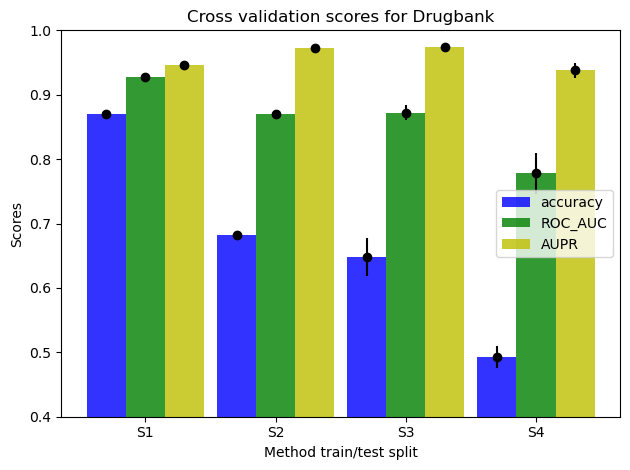

In [35]:
# faire un diagramme en barre avec la moyenne des 5fold et l'ecart type pour chaque methode


import matplotlib.pyplot as plt
import numpy as np

# data to plot
n_groups = 4
means_acc = (np.mean(DB_accuracy_S1), np.mean(DB_accuracy_S2), np.mean(DB_accuracy_S3), np.mean(DB_accuracy_S4))
means_ROC_AUC = (np.mean(DB_ROC_AUC_S1), np.mean(DB_ROC_AUC_S2), np.mean(DB_ROC_AUC_S3), np.mean(DB_ROC_AUC_S4))
means_AUPR = (np.mean(DB_AUPR_S1), np.mean(DB_AUPR_S2), np.mean(DB_AUPR_S3), np.mean(DB_AUPR_S4))

std_acc = (np.std(DB_accuracy_S1), np.std(DB_accuracy_S2), np.std(DB_accuracy_S3), np.std(DB_accuracy_S4))
std_ROC_AUC = (np.std(DB_ROC_AUC_S1), np.std(DB_ROC_AUC_S2), np.std(DB_ROC_AUC_S3), np.std(DB_ROC_AUC_S4))
std_AUPR = (np.std(DB_AUPR_S1), np.std(DB_AUPR_S2), np.std(DB_AUPR_S3), np.std(DB_AUPR_S4))

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, means_acc, bar_width,
alpha=opacity,
color='b',
label='accuracy')
plt.errorbar(index, means_acc, yerr=std_acc, fmt='o', color='black')

rects2 = plt.bar(index + bar_width, means_ROC_AUC, bar_width,
alpha=opacity,
color='g',
label='ROC_AUC')
plt.errorbar(index + bar_width, means_ROC_AUC, yerr=std_ROC_AUC, fmt='o', color='black')

rects3 = plt.bar(index + 2*bar_width, means_AUPR, bar_width,
alpha=opacity,
color='y',
label='AUPR')
plt.errorbar(index + 2*bar_width, means_AUPR, yerr=std_AUPR, fmt='o', color='black')

plt.xlabel('Method train/test split')
plt.ylabel('Scores')
plt.title('Cross validation scores for Drugbank')
plt.xticks(index + bar_width, ('S1', 'S2', 'S3', 'S4'))
plt.ylim(0.4,1)
plt.legend()

plt.tight_layout()
plt.show()



In [40]:
#CC
#prot orphan
CC_accuracy_S3 = [0.6969,0.6538,0.6979,0.6675,0.6485]
CC_ROC_AUC_S3 =[0.8317138727533526,0.8422335947198131,0.8701617619727693,0.8705710817373531,0.8417211317584415]
CC_AUPR_S3 = [0.8420006924094023,0.8314171092104135,0.8626386238295951,0.8528156739873833,0.8259222507093884]


#mol orphan
CC_accuracy_S2 = [0.9657,0.9639,0.9656,0.9667]
CC_ROC_AUC_S2 =[0.9891231846488197,0.989596358771878,0.989849221107195,0.990756340447076]
CC_AUPR_S2 = [0.9891171707866053,0.9898232199376731,0.9897330481795397,0.9906422243549712]

# S1
CC_accuracy_S1 = [0.9670,0.9669,0.9672]
CC_ROC_AUC_S1 =[0.9906,0.9906,0.9908]
CC_AUPR_S1 = [0.9906,0.9906,0.9908]

# S4
CC_accuracy_S4 = [0.4406,0.3944,0.4288,0.4033,0.4076]
CC_ROC_AUC_S4 =[0.8363590014408864,0.8331848926429313,0.8373726095261654,0.8259079588371503,0.8217125020541269]
CC_AUPR_S4 = [0.9599901788727725,0.9533332533554852,0.9552553556420922,0.951614489167699,0.9553475708183398]

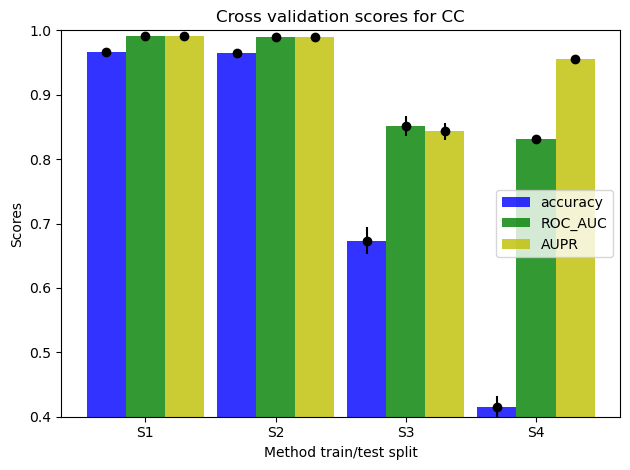

In [42]:
# faire un diagramme en barre avec la moyenne des 5fold et l'ecart type pour chaque methode


import matplotlib.pyplot as plt
import numpy as np

# data to plot
n_groups = 4
means_acc = (np.mean(CC_accuracy_S1), np.mean(CC_accuracy_S2), np.mean(CC_accuracy_S3), np.mean(CC_accuracy_S4))
means_ROC_AUC = (np.mean(CC_ROC_AUC_S1), np.mean(CC_ROC_AUC_S2), np.mean(CC_ROC_AUC_S3),    np.mean(CC_ROC_AUC_S4))
means_AUPR = (np.mean(CC_AUPR_S1), np.mean(CC_AUPR_S2), np.mean(CC_AUPR_S3), np.mean(CC_AUPR_S4))


std_acc = (np.std(CC_accuracy_S1), np.std(CC_accuracy_S2), np.std(CC_accuracy_S3), np.std(CC_accuracy_S4))
std_ROC_AUC = (np.std(CC_ROC_AUC_S1), np.std(CC_ROC_AUC_S2), np.std(CC_ROC_AUC_S3), np.std(CC_ROC_AUC_S4))
std_AUPR = (np.std(CC_AUPR_S1), np.std(CC_AUPR_S2), np.std(CC_AUPR_S3), np.std(CC_AUPR_S4))

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.3
opacity = 0.8

rects1 = plt.bar(index, means_acc, bar_width,
alpha=opacity,
color='b',
label='accuracy')
plt.errorbar(index, means_acc, yerr=std_acc, fmt='o', color='black')

rects2 = plt.bar(index + bar_width, means_ROC_AUC, bar_width,
alpha=opacity,
color='g',
label='ROC_AUC')
plt.errorbar(index + bar_width, means_ROC_AUC, yerr=std_ROC_AUC, fmt='o', color='black')

rects3 = plt.bar(index + 2*bar_width, means_AUPR, bar_width,
alpha=opacity,
color='y',
label='AUPR')
plt.errorbar(index + 2*bar_width, means_AUPR, yerr=std_AUPR, fmt='o', color='black')

plt.xlabel('Method train/test split')
plt.ylabel('Scores')
plt.title('Cross validation scores for CC')
plt.xticks(index + bar_width, ('S1', 'S2', 'S3','S4'))

# commencer y entre 0.5 et 1
plt.ylim(0.4,1)

plt.legend()

plt.tight_layout()
plt.show()